<a href="https://colab.research.google.com/github/derykroot/Aprendizadocontinuoincremental/blob/main/1_AprendizadoContinuo_EsqCatastrof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Esquecimento Catastrófico**

Como de costurme para classificação de imagens as redes neurais artificiais são treinadas apenas com um mesmo conjunto com um numero fixo de amostras que é usado para treinar varias vezes uma determinada rede neural. Contudo, no mundo real nem sempre vemos as mesmas coisas e nosso conhecimento está constantemente atualizando. O problema ocorre quando esquecemos de algo que aprendemos devido ao consumo de novas informações ao passo que não temos mais acesso a informações antigas, esse fenomeno é chamado de Esquecimento Catastrófico. Com as redes neurais artificiais ocorre o mesmo fenômeno.

Para entender mais sobre esse fenômeno simularemos o Esquecimento Catastrófico, logo em seguida testamos estratégias para diminuir o esquecimento. Nesse cenário uma rede neural com 2 classes é treinada até chegar em um nivel satisfatório de acuracia, depois é feito outro treino com novas amostras sem incluir as amostras antigas na mesma rede.


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
!wget https://github.com/derykroot/Aprendizadocontinuoincremental/blob/main/datasets.tar.gz?raw=true -O datasets.tar.gz
!tar xzf datasets.tar.gz

Funções de auxilio

In [10]:
def showimgs(imgs):
  fig, ax = plt.subplots(1, len(imgs), figsize=(15,15))
  #fig, ax = plt.subplots(1, len(imgs))
  for i in range(len(imgs)):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')
  plt.show()

def showparts(imgs, nparts = 4):
    ishow = []
    for i in range(len(imgs)):
        ishow.append(imgs[i])
        if ((i+1) % nparts) == 0:
            showimgs(ishow)
            ishow = []

# Dataset

Exemplificamos o seguinte problema para construção dos datasets: Em um cenário hipotético obtemos amostras de manuscritos de 1 e 2 e treinamos a rede neural. Em seguida percebemos que a maioria dos manuscritos estão inclinados para direita, depois obtemos os manuscritos inclinados para esquerda e treinamos a rede apenas com as novas amostras.

Para causar o esquecimento catastrófico no cenário descrito foi criado 3 datasets:

O Primeiro dataset contem 100 amostras de de manuscritos do numero *1* e 100 amostras do numero *2*, e mais 50 amostras de cada respectivamente para validação do treino, um fato importante é que neste dataset os numeros *1* estão inclinados para direita
O Segundo dataset contem mais 50 amostras de cada mais 25 de cada para validação, nessas novas amostras o numero *1* está mais reto ou inclinado para esquerda
O Terceiro dataset é a junção dos 2 dataset anteriores

O Treino do terceiro dataset servirá como base para demonstrar o desempenho do treinamento consecutivo dos outros datasets.

Para tratamento dos dados de entrada foi usado um transform com os seguintes parametros: Grayscale para deixar as imagens apenas com 1 canal de cor (MINIST originalmente é assim, mas as imagens estão em jpg com 3 canais), e Resize para aumentar um pouco a dimensão das amostras que passarão por um rede convolucional, sendo que, originalmente as amostras possuem apenas a dimensão 28x28, e passaram por 2 camadas convolucionais para extração de atributos, sem o redimensionamento a dimensão do resultado da ultima camada cnn é de 5x5 por filtro, com o redimencionameto é 10x10 por filtro

In [12]:
transform = transforms.Compose(
    [
        transforms.Resize((48,48), transforms.InterpolationMode.BICUBIC),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]
)

tset = datasets.ImageFolder('./datasets/ds/train',  transform=transform)
vset = datasets.ImageFolder('./datasets/ds/val', transform=transform) 

tsetnew = datasets.ImageFolder('./datasets/dsnew/train',  transform=transform)
vsetnew = datasets.ImageFolder('./datasets/dsnew/val', transform=transform)

tsetall = datasets.ImageFolder('./datasets/dsall/train',  transform=transform)
vsetall = datasets.ImageFolder('./datasets/dsall/val', transform=transform) 

tloader = torch.utils.data.DataLoader(tset, batch_size=32, shuffle=True)
tloaderonline = torch.utils.data.DataLoader(tset, batch_size=1, shuffle=True)
vloader = torch.utils.data.DataLoader(vset, batch_size=1, shuffle=False)

tloadernew = torch.utils.data.DataLoader(tsetnew, batch_size=32, shuffle=True)
tloaderonlinenew = torch.utils.data.DataLoader(tsetnew, batch_size=1, shuffle=True)
vloadernew = torch.utils.data.DataLoader(vsetnew, batch_size=1, shuffle=False)

tloaderall = torch.utils.data.DataLoader(tsetall, batch_size=32, shuffle=True)
tloaderonlineall = torch.utils.data.DataLoader(tsetall, batch_size=1, shuffle=True)
vloaderall = torch.utils.data.DataLoader(vsetall, batch_size=1, shuffle=False)

In [13]:
tsetall

Dataset ImageFolder
    Number of datapoints: 400
    Root location: ./datasets/dsall/train
    StandardTransform
Transform: Compose(
               Resize(size=(48, 48), interpolation=bicubic, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

Primeiro dataset, com numeros 1 levemente inclinados para direita, chamaremos de Conjunto A

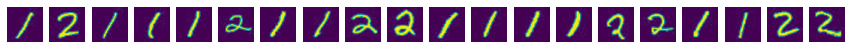

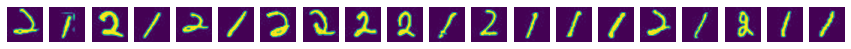

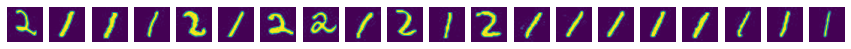

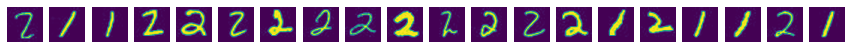

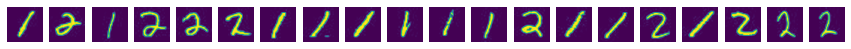

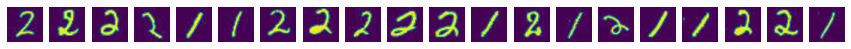

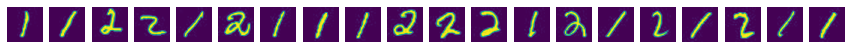

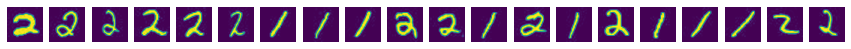

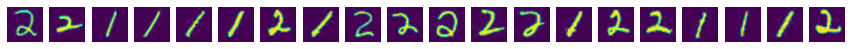

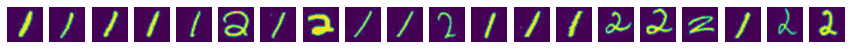

In [14]:
imgs = []
for img, _ in tloaderonline:
    imgs.append(img[0][0])
showparts(imgs, 20)

Segundo dataset, com numeros 1 levemente inclinados para esqueda\ chamaremos de Conjunto B

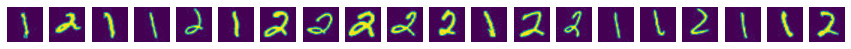

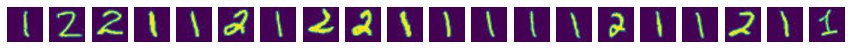

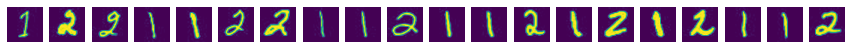

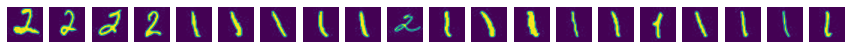

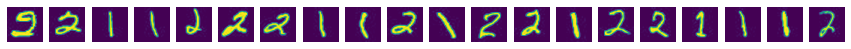

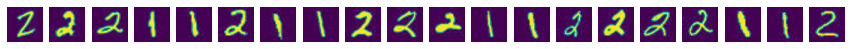

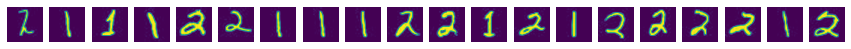

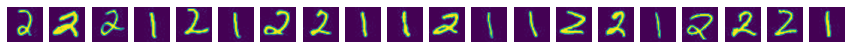

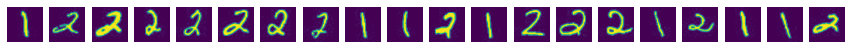

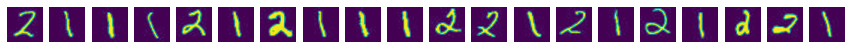

In [15]:
imgs = []
for img, _ in tloaderonlinenew:
    imgs.append(img[0][0])
showparts(imgs, 20)

**REDE CNN**

O modelo de rede para o treinamento contem 2 camadas convolucionais para extração de atributos e 3 camadas de redes neurais. A segundo rede convolucional vai entregar 64 filtros para a primeira camada neural de entrada na dimensão 10x10 por filtro. Esse mesmo modelo será utilizado em todos os treinos

In [16]:
class netmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.histloss = []
        ksize = 3 # or (3,3)
        nfilter = 32
        self.conv1 = nn.Conv2d(1, nfilter, ksize, padding=0)
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, ksize)
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(64 * (10*10), 128) 
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 3) 

        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        X = self.flatten(X) # ou X.view(-1,5*5*64)

        X = F.relu(self.linear1(X)) 
        X = F.relu(self.linear2(X)) 
        X = self.linear3(X) 

        #return X
        return F.log_softmax(X, dim=1) #  Não é necessário usar log_softmax, mas deixou o aprendizado mais estável

In [20]:
def pred(model, img):
    with torch.no_grad(): # desativar o autograd para acelerar a validação para melhor desempenho
        logps = model(img) # output do modelo em escala logaritmica

    ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
    probabs = list(ps.cpu().numpy()[0]) # converte o tensor em um número
    return probabs.index(max(probabs)), probabs # Retorna o mais provavel junto com todas as probabilidades

In [21]:
def validacao(modelo, valloader, device, nome=""):
    ctdcorretas, ctdtodas = 0, 0
    for imagens, rotulos in valloader:
      for i in range(len(rotulos)):
        img = imagens[i].view(1, 1, 48, 48)
                
        r_pred, _ = pred(modelo, img.to(device)) # converte o tensor em um número, no caso, o número que o modelo previu como correto 
        r_certo = rotulos.numpy()[i] 
        if(r_certo == r_pred): # compara a previsão da rede com o valor correto
          ctdcorretas += 1
        #else: plt.imshow(img[0][0])
        ctdtodas += 1
        

    print(nome + "Imagens testadas =", ctdtodas,". Precisão = {}%".format(ctdcorretas*100/ctdtodas)) 
    return ctdcorretas*100/ctdtodas

In [22]:
def treino(modelo, trainloader, device, otimizador, EPOCHS = 10, intervalomostra = 1):
    
    inicio = time() # timer para sabermos quanto tempo levou o treino
    
    criterio = nn.CrossEntropyLoss() 
    #criterio = nn.NLLLoss() 

    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão
        
        for imagens, rotulos in trainloader:            
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior
            
            output = modelo(imagens.to(device)) # colocando os dados no modelo

            perda_instantanea = criterio(output, rotulos.to(device)) # calculando a perda da epoch em questão
            
            perda_instantanea.backward() # back propagation a partir da perda
            
            otimizador.step() # atualizando os pesos e a bias
            
            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada        
        
        else:
            if (epoch % intervalomostra) == 0:
                print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
            modelo.histloss.append(perda_acumulada/len(trainloader))
    print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

Primeiros testes com o otimizador SGD

In [24]:
def getoptmSGD(modelo, _lr=0.001):
    return optim.SGD(modelo.parameters(), lr=_lr, momentum=0.9) # define a política de atualização dos pesos e da bias


# Treinamento em Batch (Offline)

O Primeiro treinamento será com dataset que contem todas as amostras, evidentemente terá a melhor performance e servirá para o comparativo com outros treinamentos

Epoch 1 - Perda resultante: 0.9122810134520898
Epoch 2 - Perda resultante: 0.6608794469099778
Epoch 3 - Perda resultante: 0.4448462220338675
Epoch 4 - Perda resultante: 0.2784329423537621
Epoch 5 - Perda resultante: 0.16928474547771308
Epoch 6 - Perda resultante: 0.10862708378296632
Epoch 7 - Perda resultante: 0.06902434046451862
Epoch 8 - Perda resultante: 0.05326858807641726
Epoch 9 - Perda resultante: 0.045024512049097284
Epoch 10 - Perda resultante: 0.03826724952803208
Epoch 11 - Perda resultante: 0.03192733872968417
Epoch 12 - Perda resultante: 0.028732033159870368
Epoch 13 - Perda resultante: 0.027470618987885807
Epoch 14 - Perda resultante: 0.02287398074538662
Epoch 15 - Perda resultante: 0.02185011490319784
Epoch 16 - Perda resultante: 0.021127714990423277
Epoch 17 - Perda resultante: 0.02117044120453871
Epoch 18 - Perda resultante: 0.01841179671912239
Epoch 19 - Perda resultante: 0.01515693890933807
Epoch 20 - Perda resultante: 0.01434776158286975

Tempo de treino (em minutos)

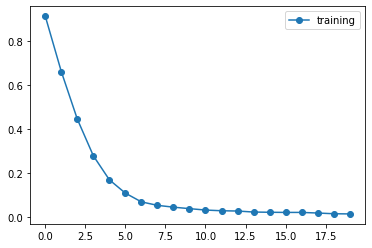

Conjunto A: Imagens testadas = 100 . Precisão = 100.0%
Conjunto B: Imagens testadas = 100 . Precisão = 100.0%


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # modelo rodará na GPU se possível

netall = netmodel()
netall.to(device)

treino(netall, tloaderall, device, getoptmSGD(netall), 20)

plt.plot(netall.histloss, 'o-', label='training')
plt.legend()
plt.show()

res_alla = validacao(netall, vloader, device, nome="Conjunto A: ")
res_allb = validacao(netall, vloadernew, device, nome="Conjunto B: ")

Por conter todas as amostras após o treinamento a rede teve um bom desempenho nos testes dos 2 conjuntos como já era esperado. Em seguida criaremos uma nova instância do mesmo modelo de rede para o treinamento Offline com apenas o primeiro conjunto de amostras 

In [26]:
netoff = netmodel()
netoff.to(device)

netmodel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=6400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=3, bias=True)
)

Faremos o treinamento do primeiro conjunto, chamaremos o primeiro conjunto de Conjunto A e o segundo conjunto treinado posteriormente como conjunto B

In [27]:
treino(netoff, tloader, device, getoptmSGD(netoff), 30)
validacao(netoff, vloader, device)

Epoch 1 - Perda resultante: 1.1302464519228255
Epoch 2 - Perda resultante: 1.003030734402793
Epoch 3 - Perda resultante: 0.867977363722665
Epoch 4 - Perda resultante: 0.752461416380746
Epoch 5 - Perda resultante: 0.6475581526756287
Epoch 6 - Perda resultante: 0.5403308314936501
Epoch 7 - Perda resultante: 0.4466889500617981
Epoch 8 - Perda resultante: 0.34783537472997395
Epoch 9 - Perda resultante: 0.25802948645183016
Epoch 10 - Perda resultante: 0.16998315283230372
Epoch 11 - Perda resultante: 0.12117003543036324
Epoch 12 - Perda resultante: 0.08420502607311521
Epoch 13 - Perda resultante: 0.06780715552823884
Epoch 14 - Perda resultante: 0.04725949918585164
Epoch 15 - Perda resultante: 0.03673668232347284
Epoch 16 - Perda resultante: 0.030639512730496272
Epoch 17 - Perda resultante: 0.0266419273934194
Epoch 18 - Perda resultante: 0.02205624883728368
Epoch 19 - Perda resultante: 0.021811240884874548
Epoch 20 - Perda resultante: 0.01725451009614127
Epoch 21 - Perda resultante: 0.0158870

98.0

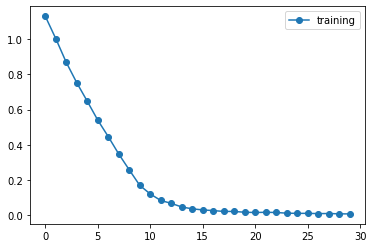

In [28]:
plt.plot(netoff.histloss, 'o-', label='training')
plt.legend()
plt.show()

In [29]:
validacao(netoff, vloader, device, nome="Conjunto A: ")
validacao(netoff, vloadernew, device, nome="Conjunto B: ")

Conjunto A: Imagens testadas = 100 . Precisão = 98.0%
Conjunto B: Imagens testadas = 100 . Precisão = 50.0%


50.0

A precisão do Conjunto B logicamente teve uma performance ruim devido a falta de amostras com caracteristicas do conjunto B no primeiro treinamento.
Logo em seguida treinaremos apenas amostras com caracteristicas do conjunto B

Treinar novo dataset

Epoch 1 - Perda resultante: 1.2692905919892448
Epoch 2 - Perda resultante: 0.3971256741455623
Epoch 3 - Perda resultante: 0.11649806797504425
Epoch 4 - Perda resultante: 0.08587190508842468
Epoch 5 - Perda resultante: 0.044527475855180194
Epoch 6 - Perda resultante: 0.026802455075085163
Epoch 7 - Perda resultante: 0.023692416426326548
Epoch 8 - Perda resultante: 0.019042609592101405
Epoch 9 - Perda resultante: 0.01724457647651434
Epoch 10 - Perda resultante: 0.015159604738333396
Epoch 11 - Perda resultante: 0.01422923178012882
Epoch 12 - Perda resultante: 0.014096904612545456
Epoch 13 - Perda resultante: 0.01250443737288671
Epoch 14 - Perda resultante: 0.016788487123059376
Epoch 15 - Perda resultante: 0.011365155789202877
Epoch 16 - Perda resultante: 0.010826302891863244
Epoch 17 - Perda resultante: 0.010667326095114862
Epoch 18 - Perda resultante: 0.011022589502057858
Epoch 19 - Perda resultante: 0.009371072519570589
Epoch 20 - Perda resultante: 0.009296118780704481
Epoch 21 - Perda r

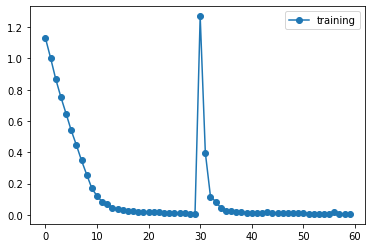

In [30]:
treino(netoff, tloadernew, device, getoptmSGD(netoff), 30)

plt.plot(netoff.histloss, 'o-', label='training')
plt.legend()
plt.show()

No gráfico percebemos que o valor de perda voltou a ser grande porque as amostras novas contem caracteristicas diferentes das amostras anteriores

In [31]:
res_offa = validacao(netoff, vloader, device, nome="Conjunto A: ")
res_offb = validacao(netoff, vloadernew, device, nome="Conjunto B: ")

Conjunto A: Imagens testadas = 100 . Precisão = 95.0%
Conjunto B: Imagens testadas = 100 . Precisão = 100.0%


Ao passo que ocorreu uma grande melhora na rede para avaliação das amostras do Conjunto B, a rede diminuiu sua performance para as amostras do Conjunto A ocasionando no fenômeno conhecido como *Esquecimento Catastrofico*

# Treinamento Online

No mundo real o treinamento incremental será comum no modo online, sendo que, nem sempre teremos um conjunto definido de novas amostras, em razão disso o treinamento da rede ocorrerá de forma online, ou seja, amostra por amostra ao invés de lotes com um conjunto de amostras

In [32]:
neton = netmodel()
neton.to(device)

netmodel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=6400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=3, bias=True)
)

Treino online é necessário menos épocas, porque o calculo de perda e a atualização dos pesos é realizado por amostra

In [34]:
treino(neton, tloaderonline, device, getoptmSGD(neton), 2)

Epoch 1 - Perda resultante: 0.0018002901517023063
Epoch 2 - Perda resultante: 0.0012477279590148171

Tempo de treino (em minutos) = 0.0659323255221049


In [35]:
validacao(neton, vloader, device, nome="Conjunto A: ")
validacao(neton, vloadernew, device, nome="Conjunto B: ")

Conjunto A: Imagens testadas = 100 . Precisão = 100.0%
Conjunto B: Imagens testadas = 100 . Precisão = 50.0%


50.0

Epoch 1 - Perda resultante: 0.10422647069764707
Epoch 2 - Perda resultante: 0.022109852423155517

Tempo de treino (em minutos) = 0.06490043799082439


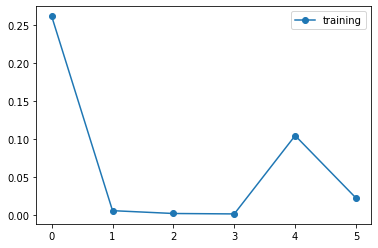

In [36]:
treino(neton, tloaderonlinenew, device, getoptmSGD(neton), 2)

plt.plot(neton.histloss, 'o-', label='training')
plt.legend()
plt.show()

In [37]:
res_ona = validacao(neton, vloader, device, nome="Conjunto A: ")
res_onb = validacao(neton, vloadernew, device, nome="Conjunto B: ")

Conjunto A: Imagens testadas = 100 . Precisão = 95.0%
Conjunto B: Imagens testadas = 100 . Precisão = 99.0%


Observamos o mesmo fenômeno de esquecimento catastrófico para as amostras do Conjunto A.

[3.6765807e-05, 0.9999497, 1.357282e-05]
Resultado da predição:  2


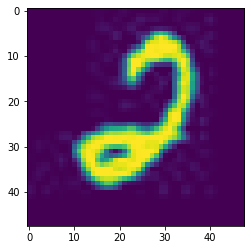

In [38]:
# Teste de uma amostra
img, idx = vsetnew[66]
plt.imshow(img[0])

img = img.view(1, 1, 48, 48) # Formato (batch_size, número de canais, altura largura)
rpred, probs = pred(neton, img.to(device))

print(probs) 
print("Resultado da predição: ",rpred+1)

# EWC

Um dos primeiros algoritmos criados para amenizar o esquecimento catastrófico para redes neurais é o EWC (Elastic weight consolidation), apesar de não ter uma boa performance comparado a algoritmos mais recentes, serve de base para fazer comparativos com o desempenho de outros treinamentos

In [39]:
# Implementação adaptada com base na fonte: https://github.com/shivamsaboo17/Overcoming-Catastrophic-forgetting-in-Neural-Networks
class ElasticWeightConsolidation:

    def __init__(self, model, crit, weight=int(1e+7)):
        self.model = model
        self.weight = weight
        self.crit = crit
        # self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9) # optim.Adam(self.model.parameters(), lr)

    def _update_mean_params(self):
        for param_name, param in self.model.named_parameters():
            _buff_param_name = param_name.replace('.', '__')
            self.model.register_buffer(_buff_param_name+'_estimated_mean', param.data.clone())

    def _update_fisher_params(self, current_ds, batch_size, num_batch, device="cpu"):
        dl = current_ds
        log_liklihoods = []
        for i, (input, target) in enumerate(dl):
            if i > num_batch:
                break
            output = F.log_softmax(self.model(input.to(device)), dim=1)
            log_liklihoods.append(output[:, target.to(device)])
        log_likelihood = torch.cat(log_liklihoods).mean()
        grad_log_liklihood = torch.autograd.grad(log_likelihood, self.model.parameters())
        _buff_param_names = [param[0].replace('.', '__') for param in self.model.named_parameters()]
        for _buff_param_name, param in zip(_buff_param_names, grad_log_liklihood):
            self.model.register_buffer(_buff_param_name+'_estimated_fisher', param.data.clone() ** 2)

    def register_ewc_params(self, dataset, batch_size, num_batches, device="cpu"):
        self._update_fisher_params(dataset, batch_size, num_batches, device)
        self._update_mean_params()

    def _compute_consolidation_loss(self, weight):
        try:
            losses = []
            for param_name, param in self.model.named_parameters():
                _buff_param_name = param_name.replace('.', '__')
                estimated_mean = getattr(self.model, '{}_estimated_mean'.format(_buff_param_name))
                estimated_fisher = getattr(self.model, '{}_estimated_fisher'.format(_buff_param_name))
                losses.append((estimated_fisher * (param - estimated_mean) ** 2).sum())
            return (weight / 2) * sum(losses)
        except AttributeError:
            return 0

    def forward_backward_update(self, input, target, otimizador):
        output = self.model(input)
        loss = self._compute_consolidation_loss(self.weight) + self.crit(output, target)
        otimizador.zero_grad()
        loss.backward()
        otimizador.step()
        return loss

    def treino(self, dsloader, epocas, device, otimizador):
        for epoch in range(epocas):
            perda_acumulada = 0
            for input, target in dsloader:
                loss =  self.forward_backward_update(input.to(device), target.to(device), otimizador)
                #self.register_ewc_params([[input, target]], 1, 1, device)
                perda_acumulada += loss
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(dsloader)))
            hist = perda_acumulada/len(dsloader)
            self.model.histloss.append(hist.item())

In [40]:
ewc = ElasticWeightConsolidation(netmodel(), crit=nn.CrossEntropyLoss())
ewc.model.to(device)

netmodel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=6400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=3, bias=True)
)

Usamos o EWC para treinamento online

In [41]:
ewc.treino(tloaderonline, 2, device, getoptmSGD(ewc.model))
# treino(ewc.model, tloaderonline, device, 2)

ewc.register_ewc_params(tloaderonline, 1, 100, device)

Epoch 1 - Perda resultante: 0.21222412586212158
Epoch 2 - Perda resultante: 0.005448663607239723


In [42]:
validacao(ewc.model, vloader, device)
validacao(ewc.model, vloadernew, device)

Imagens testadas = 100 . Precisão = 100.0%
Imagens testadas = 100 . Precisão = 52.0%


52.0

In [43]:
ewc.treino(tloaderonlinenew, 2, device, getoptmSGD(ewc.model))

Epoch 1 - Perda resultante: 0.16435542702674866
Epoch 2 - Perda resultante: 0.024634379893541336


In [44]:
res_ewca = validacao(ewc.model, vloader, device, nome="Conjunto A: ")
res_ewcb = validacao(ewc.model, vloadernew, device, nome="Conjunto B: ")

Conjunto A: Imagens testadas = 100 . Precisão = 96.0%
Conjunto B: Imagens testadas = 100 . Precisão = 100.0%


Observamos que tambem ouve o esquecimento para o conjunto A, lembrando que EWC não evita o esquecimento, apenas ameniza

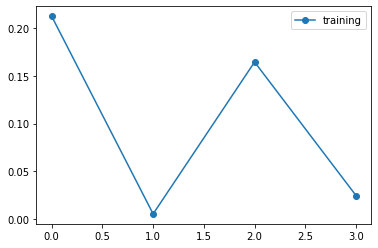

In [45]:
plt.plot(ewc.model.histloss, 'o-', label='training')
plt.legend()
plt.show()

# Low Learning Rate (Menor taxa de aprendizado)

Será realizado os mesmos testes mas com uma taxa de aprendizado menor

**Treino Offline**

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 1.1657815831048148
Epoch 11 - Perda resultante: 0.8828803726605007
Epoch 21 - Perda resultante: 0.6947562098503113
Epoch 31 - Perda resultante: 0.47470176219940186
Epoch 41 - Perda resultante: 0.30257665685244967
Epoch 51 - Perda resultante: 0.19803651315825327
Epoch 61 - Perda resultante: 0.12521676187004363
Epoch 71 - Perda resultante: 0.08882712147065572
Epoch 81 - Perda resultante: 0.06357794308236667
Epoch 91 - Perda resultante: 0.0457575757588659

Tempo de treino (em minutos) = 1.0828027645746867
Conjunto A. Imagens testadas = 100 . Precisão = 100.0%
Conjunto B. Imagens testadas = 100 . Precisão = 50.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 1.1296778321266174
Epoch 11 - Perda resultante: 0.176070864711489
Epoch 21 - Perda resultante: 0.09765403824193138
Epoch 31 - Perda resultante: 0.059984754770994186
Epoch 41 - Perda resultante: 0.04315525053867272
Epoch 51 - Perda resultante: 0.0354739627

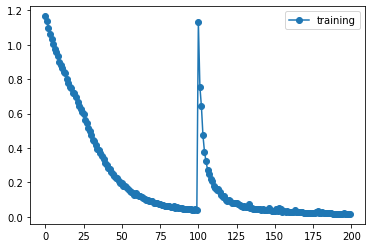


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 96.0%
Conjunto B. Imagens testadas = 100 . Precisão = 100.0%


In [46]:
netoff = netmodel()
netoff.to(device)

llr = 1e-4
print("======== Primeiro Treino ==========")
treino(netoff, tloader, device, getoptmSGD(netoff, llr), 100,intervalomostra=10)

validacao(netoff, vloader, device, nome = "Conjunto A. ")
validacao(netoff, vloadernew, device, nome = "Conjunto B. ")

print("\n======== Segundo Treino ==========")
treino(netoff, tloadernew, device, getoptmSGD(netoff, llr), 100,intervalomostra=10)

plt.plot(netoff.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
resllr_offa = validacao(netoff, vloader, device, nome = "Conjunto A. ")
resllr_offb = validacao(netoff, vloadernew, device, nome = "Conjunto B. ")

**Treino Online**

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 0.7252907807379961
Epoch 2 - Perda resultante: 0.21678343680687248
Epoch 3 - Perda resultante: 0.06504726164479507
Epoch 4 - Perda resultante: 0.03476118322709226
Epoch 5 - Perda resultante: 0.02081839202667652
Epoch 6 - Perda resultante: 0.014887246334874362

Tempo de treino (em minutos) = 0.2043488621711731
Conjunto A. Imagens testadas = 100 . Precisão = 100.0%
Conjunto B. Imagens testadas = 100 . Precisão = 51.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 0.1851740885576146
Epoch 2 - Perda resultante: 0.03122085699764284
Epoch 3 - Perda resultante: 0.021401064028373183
Epoch 4 - Perda resultante: 0.017410078206885372
Epoch 5 - Perda resultante: 0.013270275726542878
Epoch 6 - Perda resultante: 0.010466984399557192

Tempo de treino (em minutos) = 0.19990642865498862


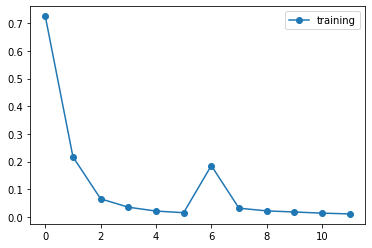


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 97.0%
Conjunto B. Imagens testadas = 100 . Precisão = 100.0%


In [48]:
neton = netmodel()
neton.to(device)

llr = 1e-4
print("======== Primeiro Treino ==========")
treino(neton, tloaderonline, device, getoptmSGD(neton, llr), 6)

validacao(neton, vloader, device, nome = "Conjunto A. ")
validacao(neton, vloadernew, device, nome = "Conjunto B. ")

print("\n======== Segundo Treino ==========")
treino(neton, tloaderonlinenew, device, getoptmSGD(neton, llr), 6)

plt.plot(neton.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
resllr_ona = validacao(neton, vloader, device, nome = "Conjunto A. ")
resllr_onb = validacao(neton, vloadernew, device, nome = "Conjunto B. ")

**EWC**

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 0.8054408431053162
Epoch 2 - Perda resultante: 0.39736703038215637
Epoch 3 - Perda resultante: 0.16282063722610474
Epoch 4 - Perda resultante: 0.07098796218633652
Epoch 5 - Perda resultante: 0.04038575291633606
Epoch 6 - Perda resultante: 0.026097828522324562
Conjunto A. Imagens testadas = 100 . Precisão = 97.0%
Conjunto B. Imagens testadas = 100 . Precisão = 50.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 0.35207846760749817
Epoch 2 - Perda resultante: 0.1347866654396057
Epoch 3 - Perda resultante: 0.10613645613193512
Epoch 4 - Perda resultante: 0.089936763048172
Epoch 5 - Perda resultante: 0.07828299701213837
Epoch 6 - Perda resultante: 0.07145238667726517


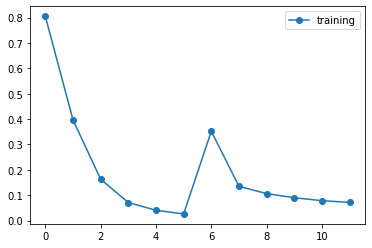


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 98.0%
Conjunto B. Imagens testadas = 100 . Precisão = 100.0%


In [49]:
ewc = ElasticWeightConsolidation(netmodel(), crit=nn.CrossEntropyLoss())
ewc.model.to(device)

llr = 1e-4
print("======== Primeiro Treino ==========")
ewc.treino(tloaderonline, 6, device, getoptmSGD(ewc.model, llr))

ewc.register_ewc_params(tloaderonline, 6, 100, device)

validacao(ewc.model, vloader, device, nome = "Conjunto A. ")
validacao(ewc.model, vloadernew, device, nome = "Conjunto B. ")

print("\n======== Segundo Treino ==========")
ewc.treino(tloaderonlinenew, 6, device, getoptmSGD(ewc.model, llr))

plt.plot(ewc.model.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
resllr_ewca = validacao(ewc.model, vloader, device, nome = "Conjunto A. ")
resllr_ewcb = validacao(ewc.model, vloadernew, device, nome = "Conjunto B. ")

Com a diminuição da taxa de aprendizado ocorreu uma melhora em relação ao esquecimento das amostras do conjunto A em todos os treinos com destaque na melhor performance do treino com EWC. Reparamos no gráfico que a curva da perda do treino EWC é mais lenta, sendo que a atualização dos pesos é mais tenue comparado com a atualização dos outros treinos

# Otimizador AdamW

In [50]:
def getoptmAdamW(modelo, _lr=0.0001):
    return torch.optim.AdamW(modelo.parameters(), lr=_lr)

**Treino Offline com AdamW**

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 0.9918091808046613
Epoch 11 - Perda resultante: 0.015648430612470423
Epoch 21 - Perda resultante: 0.002806033124215901
Epoch 31 - Perda resultante: 0.0011747352005581238
Epoch 41 - Perda resultante: 0.0006648160467323448

Tempo de treino (em minutos) = 0.5910927375157674
Conjunto A. Imagens testadas = 100 . Precisão = 100.0%
Conjunto B. Imagens testadas = 100 . Precisão = 53.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 1.0418908894062042
Epoch 11 - Perda resultante: 0.03814578994310328
Epoch 21 - Perda resultante: 0.017711581529251168
Epoch 31 - Perda resultante: 0.00912294935967241
Epoch 41 - Perda resultante: 0.006014062856723156

Tempo de treino (em minutos) = 0.5721604228019714


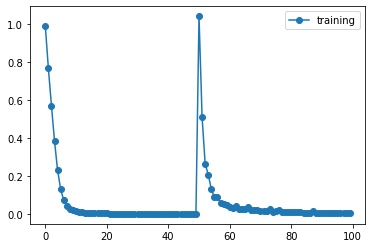


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 100.0%
Conjunto B. Imagens testadas = 100 . Precisão = 100.0%


In [51]:
netoff = netmodel()
netoff.to(device)

print("======== Primeiro Treino ==========")
treino(netoff, tloader, device, getoptmAdamW(netoff), 50,intervalomostra=10)

validacao(netoff, vloader, device, nome = "Conjunto A. ")
validacao(netoff, vloadernew, device, nome = "Conjunto B. ")

print("\n======== Segundo Treino ==========")
treino(netoff, tloadernew, device, getoptmAdamW(netoff), 50,intervalomostra=10)

plt.plot(netoff.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
resadamw_offa = validacao(netoff, vloader, device, nome = "Conjunto A. ")
resadamw_offb = validacao(netoff, vloadernew, device, nome = "Conjunto B. ")

**Treino Online com AdamW**

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 0.21040782174164632
Epoch 2 - Perda resultante: 0.005958674228729813
Epoch 3 - Perda resultante: 0.0015879352930490143

Tempo de treino (em minutos) = 0.16109707355499267
Conjunto A. Imagens testadas = 100 . Precisão = 100.0%
Conjunto B. Imagens testadas = 100 . Precisão = 53.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 0.3459342098002861
Epoch 2 - Perda resultante: 0.020989943869503803
Epoch 3 - Perda resultante: 0.01939914477920482

Tempo de treino (em minutos) = 0.1767707904179891


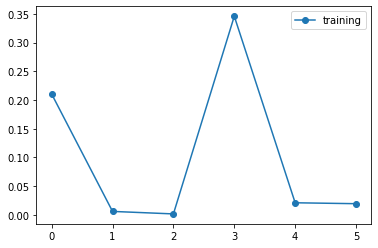


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 99.0%
Conjunto B. Imagens testadas = 100 . Precisão = 100.0%


In [52]:
neton = netmodel()
neton.to(device)

print("======== Primeiro Treino ==========")
treino(neton, tloaderonline, device, getoptmAdamW(neton), 3)

validacao(neton, vloader, device, nome = "Conjunto A. ")
validacao(neton, vloadernew, device, nome = "Conjunto B. ")

print("\n======== Segundo Treino ==========")
treino(neton, tloaderonlinenew, device, getoptmAdamW(neton), 3)

plt.plot(neton.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
resadamw_ona = validacao(neton, vloader, device, nome = "Conjunto A. ")
resadamw_onb = validacao(neton, vloadernew, device, nome = "Conjunto B. ")

**Treino EWC com AdamW**

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 0.18563129007816315
Epoch 2 - Perda resultante: 0.007044196594506502
Epoch 3 - Perda resultante: 0.0019544651731848717
Conjunto A. Imagens testadas = 100 . Precisão = 100.0%
Conjunto B. Imagens testadas = 100 . Precisão = 52.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 0.445995569229126
Epoch 2 - Perda resultante: 0.03811877220869064
Epoch 3 - Perda resultante: 0.031320128589868546


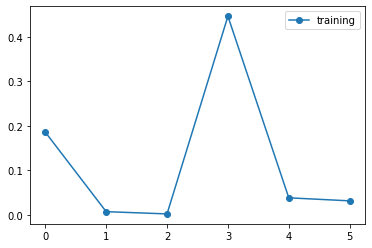


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 99.0%
Conjunto B. Imagens testadas = 100 . Precisão = 100.0%


In [53]:
ewc = ElasticWeightConsolidation(netmodel(), crit=nn.CrossEntropyLoss())
ewc.model.to(device)

print("======== Primeiro Treino ==========")
ewc.treino(tloaderonline, 3, device, getoptmAdamW(ewc.model))

ewc.register_ewc_params(tloaderonline, 1, 100, device)

validacao(ewc.model, vloader, device, nome = "Conjunto A. ")
validacao(ewc.model, vloadernew, device, nome = "Conjunto B. ")

print("\n======== Segundo Treino ==========")
ewc.treino(tloaderonlinenew, 3, device, getoptmAdamW(ewc.model))

plt.plot(ewc.model.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
resadamw_ewca = validacao(ewc.model, vloader, device, nome = "Conjunto A. ")
resadamw_ewcb = validacao(ewc.model, vloadernew, device, nome = "Conjunto B. ")

Todos os treinos com AdamW desempenham uma boa performance em relação ao esquecimento catastrófico com destaque para uma melhora significativa do treino Offline, além da vantagem de necessitar menos epocas no treino para obter boa acurácia nas avaliações

In [56]:
def byres(r):
    return r[1]

resultados = [["Treino com todos conjustos",  res_alla]]
resultados += [["Offline SGD Conjunto A", res_offa]]
resultados += [["Online SGD Conjunto A", res_ona]]
resultados += [["EWC SGD Conjunto A", res_ewca]]
resultados += [["Offline SGD Low LR Conjunto A", resllr_offa]]
resultados += [["Online SGD Low LR Conjunto A", resllr_ona]]
resultados += [["EWC SGD Low LR Conjunto A", resllr_ewca]]
resultados += [["Offline AdamW Conjunto A", resadamw_offa]]
resultados += [["Online AdamW Conjunto A", resadamw_ona]]
resultados += [["EWC AdamW Conjunto A", resadamw_ewca]]

print("Resultados ordenados do pior para o melhor:\n")
resultados.sort(key=byres)
for res in resultados:
    print(res[0], ":", res[1])

Resultados ordenados do pior para o melhor:

Offline SGD Conjunto A : 95.0
Online SGD Conjunto A : 95.0
EWC SGD Conjunto A : 96.0
Offline SGD Low LR Conjunto A : 96.0
Online SGD Low LR Conjunto A : 97.0
EWC SGD Low LR Conjunto A : 98.0
Online AdamW Conjunto A : 99.0
EWC AdamW Conjunto A : 99.0
Treino com todos conjustos : 100.0
Offline AdamW Conjunto A : 100.0
